<a href="https://colab.research.google.com/github/Lasvut/DLIGroupAssignmentJ/blob/main/GroupJ_DLIAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks


#Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import SelectFromModel


#Reproductibility
SEED = 42



# Data Loading

In [13]:
#Mount Drive

from google.colab import drive
drive.mount('/content/drive')
data_path = ('/content/drive/MyDrive/PhiUSIIL_Phishing_URL_Dataset.csv')

#Import Dataset
df = pd.read_csv(data_path)

print('Shape: ', df.shape)
print('Columns: ', list(df.columns)[:10], '...')
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (235795, 56)
Columns:  ['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb'] ...


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


# Pre-processing



In [14]:
text_col = ['FILENAME', 'URL', 'Domain', 'Title']
target_col = 'label'

print('Original shape: ', df.shape)

#==========================Data Cleaning===========================

#Drop empty rows
df = df.dropna(how='all')

#Drop rows with missing label; label: phishing 1, legit 0
df = df.dropna(subset=[target_col])

#Drop duplicaeds by FILENAME and URL
if 'FILENAME' in df.columns:
  df = df.drop_duplicates(subset='FILENAME')
elif 'URL' in df.columns:
  df = df.drop_duplicates(subset='URL')

#Strop whitespace
for col in df.select_dtypes(include=['object']).columns:
  df[col] = df[col].astype(str).str.strip()

#Drop raw text col
for c in text_col:
  if c in df.columns:
    df = df.drop(columns=[c])

#Ensure target col exist
assert target_col in df.columns, f'Target column "{target_col}" not found.'

#Convert columns to numeric
feature_col = [c for c in df.columns if c != target_col]
X_raw = df[feature_col].apply(pd.to_numeric, errors='coerce')
y = df[target_col].astype(int)

#===========================Noice filtering==========================

#Ratios and Prob should always between 0 and 1
ratio_col = [c for c in X_raw.columns if 'Ratio' in c or 'Prob' in c]
for col in ratio_col:
  if col in X_raw.columns:
    bad_idx = X_raw[(X_raw[col] < 0) | (X_raw[col] > 1)].index
    if len(bad_idx) > 0:
      print(f'Dropping {len(bad_idx)} noisy rows from {col}')
      X_raw = X_raw.drop(index=bad_idx)
      y = y.drop(index=bad_idx)

#Remove negative values from count columns
count_col = [c for c in X_raw.columns if 'Length' in c or 'NoOf' in c or 'Line' in c]
for col in count_col:
  if col in X_raw.columns:
    bad_idx = X_raw[X_raw[col] < 0].index
    if len(bad_idx) > 0:
      print(f'Dropping {len(bad_idx)} rows with negative value in {col}')
      X_raw = X_raw.drop(index=bad_idx)
      y = y.drop(index=bad_idx)

#Fills NaNs with medians
X_raw = X_raw.fillna(X_raw.median(numeric_only=True))

print('After cleaning: ', X_raw.shape)

#=============================Class balancing=========================================

#Class balancing with ROS
print('Initial Class Distribution: ')
print(y.value_counts(dropna=False).sort_index())

ros = RandomOverSampler(random_state=SEED)
X_bal, y_bal = ros.fit_resample(X_raw, y)

print('\nAfter RandomOverSampler: ')
print(y_bal.value_counts(dropna=False).sort_index())

#============================Train-test split (80/20)====================================

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=SEED, stratify=y_bal
)

print('\nTrain shape: ', X_train_raw.shape, 'Test shape: ', X_test_raw.shape)

Original shape:  (235795, 56)
After cleaning:  (235795, 51)
Initial Class Distribution: 
label
0    100945
1    134850
Name: count, dtype: int64

After RandomOverSampler: 
label
0    134850
1    134850
Name: count, dtype: int64

Train shape:  (215760, 51) Test shape:  (53940, 51)


Optional Pre-processing: Ridge Regression-based Feature Selection

In [15]:
def ridge_feature_selection(X_train, X_test, y_train, feature_col):
  #===========================Scalar features============================

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_raw)
  X_test_scaled = scaler.transform(X_test_raw) #Changed fit_transform to transform just in case test set is "leaked" unto the model

  #==========================Ridge with Cross-validation==================

  ridge = RidgeClassifierCV(
      alphas = np.logspace(-3, 3, 13), cv = 5
  )

  #Select Informative Feature
  selector = SelectFromModel(estimator=ridge, threshold='median')
  selector.fit(X_train_scaled, y_train)

  #Check number of selected features
  selected_mask = selector.get_support()
  num_selected = selected_mask.sum()

  #========================Transform data================================

  X_train_fs = selector.transform(X_train_scaled)
  X_test_fs = selector.transform(X_test_scaled)

  #Track selected features
  selected_features = np.array(feature_col)[selected_mask]

  print(f'Selected features: {num_selected}/{len(feature_col)}')
  print('Top features: ', list(selected_features))

  return X_train_fs, X_test_fs, selected_features, scaler, selector #Added scaler and selector to return for easier model saving

Lim Jia Wei TP066781

In [16]:
#Libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42

#Columns
text_col = ['FILENAME', 'URL', 'Domain', 'Title']
target_col = 'label'

print("\n🔹 Original shape:", df.shape)

#Data Cleaning
# Drop empty rows
df = df.dropna(how='all')

# Drop rows with missing label
df = df.dropna(subset=[target_col])

# Drop duplicates by FILENAME or URL
if 'FILENAME' in df.columns:
    df = df.drop_duplicates(subset='FILENAME')
elif 'URL' in df.columns:
    df = df.drop_duplicates(subset='URL')

# Strip whitespace
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

# Drop raw text cols
for c in text_col:
    if c in df.columns:
        df = df.drop(columns=[c])

# Ensure target col exists
assert target_col in df.columns, f"Target column {target_col} not found."

# Convert columns to numeric
feature_col = [c for c in df.columns if c != target_col]
X_raw = df[feature_col].apply(pd.to_numeric, errors='coerce')
y = df[target_col].astype(int)

#Noise Filtering
# Ratios and Prob columns must be between 0 and 1
ratio_col = [c for c in X_raw.columns if 'Ratio' in c or 'Prob' in c]
for col in ratio_col:
    bad_idx = X_raw[(X_raw[col] < 0) | (X_raw[col] > 1)].index
    if len(bad_idx) > 0:
        print(f"Dropping {len(bad_idx)} noisy rows from {col}")
        X_raw = X_raw.drop(index=bad_idx)
        y = y.drop(index=bad_idx)

# Remove negative values from count columns
count_col = [c for c in X_raw.columns if 'Length' in c or 'NoOf' in c or 'Line' in c]
for col in count_col:
    bad_idx = X_raw[X_raw[col] < 0].index
    if len(bad_idx) > 0:
        print(f"Dropping {len(bad_idx)} rows with negative value in {col}")
        X_raw = X_raw.drop(index=bad_idx)
        y = y.drop(index=bad_idx)

# Fill NaNs with medians
X_raw = X_raw.fillna(X_raw.median(numeric_only=True))

print("After cleaning:", X_raw.shape)

#Class Balancing
print("\nInitial Class Distribution:\n", y.value_counts().sort_index())

ros = RandomOverSampler(random_state=SEED)
X_bal, y_bal = ros.fit_resample(X_raw, y)

print("\nAfter RandomOverSampler:\n", y_bal.value_counts().sort_index())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=SEED, stratify=y_bal
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


🔹 Original shape: (235795, 52)
After cleaning: (235795, 51)

Initial Class Distribution:
 label
0    100945
1    134850
Name: count, dtype: int64

After RandomOverSampler:
 label
0    134850
1    134850
Name: count, dtype: int64

Train shape: (215760, 51) Test shape: (53940, 51)


# Model

ANN - Tan Mu Yuan(TP069241)

In [17]:
X_train_fs, X_test_fs, selected_features, scaler, selector = ridge_feature_selection(
    X_train, X_test, y_train, feature_col #Changed X_train_raw and X_test_raw to X_train and X_test since its already test splitted and latest
)

def build_ann(input_dim: int) -> tf.keras.Model:
  inputs = layers.Input(shape=(input_dim,))

  #layer 1
  x = layers.Dense(128, activation='relu')(inputs)
  x = layers.Dropout(0.3)(x)

  #layer 2
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.2)(x)

  #layer 3
  x = layers.Dense(32, activation='relu')(x)

  #Output layer
  outputs = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model(inputs,outputs, name='Phishing_URL_Detection_using_ANN')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy',
      metrics=['accuracy']
  )
  return model

#Build mode using selected features
input_dim = X_train_fs.shape[1]
model = build_ann(input_dim)
model.summary()
print('Trainable Parameters: ', model.count_params())


Selected features: 26/51
Top features:  [np.str_('URLLength'), np.str_('IsDomainIP'), np.str_('URLSimilarityIndex'), np.str_('TLDLegitimateProb'), np.str_('TLDLength'), np.str_('NoOfSubDomain'), np.str_('NoOfLettersInURL'), np.str_('LetterRatioInURL'), np.str_('NoOfDegitsInURL'), np.str_('DegitRatioInURL'), np.str_('NoOfEqualsInURL'), np.str_('NoOfAmpersandInURL'), np.str_('NoOfOtherSpecialCharsInURL'), np.str_('SpacialCharRatioInURL'), np.str_('IsHTTPS'), np.str_('DomainTitleMatchScore'), np.str_('URLTitleMatchScore'), np.str_('HasFavicon'), np.str_('Robots'), np.str_('NoOfURLRedirect'), np.str_('HasDescription'), np.str_('HasSocialNet'), np.str_('HasSubmitButton'), np.str_('HasHiddenFields'), np.str_('HasCopyrightInfo'), np.str_('NoOfJS')]


Model: "Phishing_URL_Detection_using_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

Trainable Parameters:  13825


# Training

ANN - Tan Mu Yuan(TP069241)

In [18]:
early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 10, restore_best_weights = True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-5
)

ann_history = model.fit(
    X_train_fs, y_train,
    validation_data=(X_test_fs, y_test),
    epochs = 50,
    batch_size = 256,
    callbacks = [early_stop, reduce_lr],
    verbose = 1
)

Epoch 1/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9820 - loss: 0.0588 - val_accuracy: 0.9996 - val_loss: 9.4698e-04 - learning_rate: 0.0010
Epoch 2/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9997 - loss: 9.4757e-04 - val_accuracy: 0.9998 - val_loss: 5.9647e-04 - learning_rate: 0.0010
Epoch 3/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9998 - loss: 7.2872e-04 - val_accuracy: 0.9998 - val_loss: 5.3267e-04 - learning_rate: 0.0010
Epoch 4/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9998 - loss: 6.9849e-04 - val_accuracy: 0.9999 - val_loss: 3.9361e-04 - learning_rate: 0.0010
Epoch 5/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9999 - loss: 4.9005e-04 - val_accuracy: 0.9999 - val_loss: 4.6833e-04 - learning_rate: 0.0010
Epoch 6/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9999 - loss: 3.7253e-04 - val_accuracy: 0.9998 - val_loss: 6.0870e-04 - learning_rate: 0.0010
Epoch 7/50
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 5

GBC - Lim Jia Wei (TP066781)

In [21]:
#Gradient Boosting
print("\nTraining GradientBoostingClassifier...")

gbc = GradientBoostingClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.9,
    max_features="sqrt",
    random_state=SEED
)

gbc.fit(X_train, y_train)

# Predictions
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)[:, 1]


Training GradientBoostingClassifier...


# Implementation of both models (ANN+GBC)

Model Stacking (Meta Classifier) TP068432 Runtime:859s

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report)
import numpy as np

#Split training set into inner-train and validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

#Build ANN inputs for inner split with previous scaler and selector
X_tr_fs=selector.transform(scaler.transform(X_tr))
X_val_fs=selector.transform(scaler.transform(X_val))

#Train base model on inner-train (Fresh model for OOF-validation)
#Retrains both model in a split inner-train
gbc_oof=GradientBoostingClassifier(
    n_estimators=2000, learning_rate= 0.01, max_depth=7, min_samples_split=5, min_samples_leaf=2, subsample=0.9, max_features="sqrt", random_state=SEED
).fit(X_tr, y_tr)

ann_oof=build_ann(input_dim=X_tr_fs.shape[1])
_=ann_oof.fit(
    X_tr_fs, y_tr,
    validation_data=(X_val_fs, y_val),
    epochs=50, batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

#Validation probabilities from inner models
proba_gbc_val=gbc_oof.predict_proba(X_val)[:,1]
proba_ann_val=ann_oof.predict(X_val_fs, verbose=0).ravel()
meta_x_val=np.column_stack([proba_ann_val,proba_gbc_val])
meta_y_val=y_val

#Train meta-classifier on validation prediction
meta_clf=LogisticRegression(max_iter=1000, random_state=SEED).fit(meta_x_val, meta_y_val)

#Evaluate on true held-out TEST set using full models
#Prepare ANN input for test
X_test_fs=selector.transform(scaler.transform(X_test))

proba_gbc_test=gbc.predict_proba(X_test)[:,1]
proba_ann_test=model.predict(X_test_fs, verbose=0).ravel()

meta_X_test=np.column_stack([proba_ann_test, proba_gbc_test])
proba_stack=meta_clf.predict_proba(meta_X_test)[:, 1]
pred_stack=(proba_stack>=0.5).astype(int)

print("\n====Stacking Ensemble (Meta on Validation, Eval on test)====")
print(f"Accuracy: {accuracy_score(y_test, pred_stack):.4f}")
print(f"Precision: {precision_score(y_test, pred_stack):.4f}")
print(f"Recall: {recall_score(y_test, pred_stack):.4f}")
print(f"F1-Score: {f1_score(y_test, pred_stack):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, proba_stack):.4f}")
print(f"Log Loss: {log_loss(y_test, proba_stack):.4f}")
print("\nClassification Report:\n", classification_report(y_test, pred_stack))

#joblib.dump(meta_clf, 'artifacts/meta_classifier.joblib') if uses this


====Stacking Ensemble (Meta on Validation, Eval on test)====
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000
Log Loss: 0.0005

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



# Evaluation

Lim Jia Wei - TP066781

In [23]:
#Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
loss = log_loss(y_test, y_pred_proba)

print("\n=== Gradient Boosting Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")
print(f"Log Loss : {loss:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


=== Gradient Boosting Results ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000
Log Loss : 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26970
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



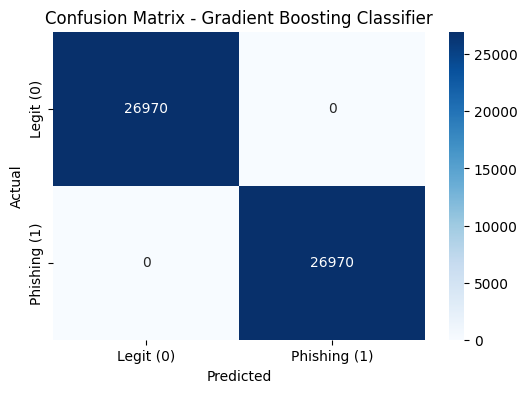

In [24]:
from sklearn.metrics import confusion_matrix

#Generate confusion matrix
cm = confusion_matrix(y_test, pred_stack)

#plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit (0)", "Phishing (1)"],
            yticklabels=["Legit (0)", "Phishing (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.show()


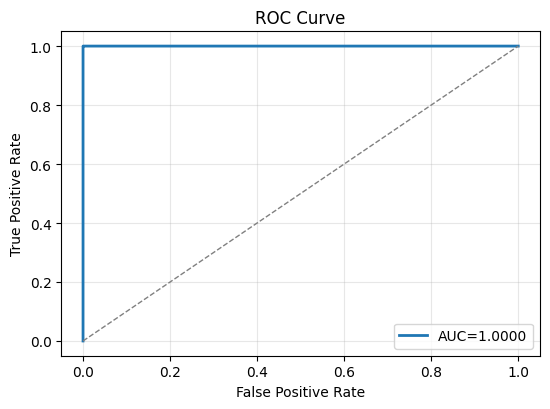

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, proba_stack)
auc = roc_auc_score(y_test, proba_stack)

plt.figure(figsize=(5.6,4.2))
plt.plot(fpr, tpr, lw=2, label=f'AUC={auc:.4f}')
plt.plot([0,1],[0,1],'--',lw=1,color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Save Model

Tan Sin Hong TP068432

In [26]:
import joblib, json, os
#Save sklearn objects and small JSON file for feature names
os.makedirs("artifacts",exist_ok=True)
#Dump GBC
joblib.dump(gbc, "artifacts/gbc_model.joblib")
#Save ANN Processing artifacts and model
joblib.dump(scaler, "artifacts/ann_scaler.joblib")
joblib.dump(selector, "artifacts/ann_selector.joblib")
model.save("artifacts/ann_model.keras")
joblib.dump(meta_clf, "artifacts/meta_clf.joblib")

#Save selected feature names and training feature order
with open("artifacts/selected_features.json","w") as f:
  json.dump(list(map(str, selected_features)), f)

with open("artifacts/feature_order.json","w") as f:
  json.dump(list(map(str, feature_col)), f)

Option 1: Push the artifacts into a git repo (still investigating might be dangerous dont run first)

In [ ]:
!git config --global user.name Lasvut

!git clone https://github.com/Lasvut/DLIGroupAssignmentJ.git

import shutil
shutil.move("artifacts","/content/DLIGroupAsssignmentJ/artifacts")

%cd /content/DLIGroupAssignmentJ

!git add artifacts
!git commit -m "Updated artifacts to repository"
!git push origin main

Option 2: Download Artifacts

In [27]:
from google.colab import files
import shutil
zip_filename="/content/artifacts.zip"
shutil.make_archive(zip_filename.replace('.zip',''),'zip',"artifacts")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Option 2: Save the artifacts into your Google Drive

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

os.makedirs("/content/drive/MyDrive/Phish_URL_ML_Artifacts", exist_ok=True)
shutil.copytree("artifacts","/content/drive/MyDrive/Phish_URL_ML_Artifacts")

#GUI

Tan Sin Hong TP068432 (Gradio)

In [31]:
import gradio as gr
import joblib
import numpy as np
import pandas as pd
import json

#Load the model
grad_model=joblib.load('artifacts/meta_clf.joblib')
feature_col=json.load(open("artifacts/selected_features.json"))

def predict(input_data):
  if isinstance(input_data, str): #Check if input data is an URL
    features=extract_features_from_url(input_data)
    #Both applies if the model requires scaling and feature selecting (ANN)
    X=[features]
  else:
    df=pd.read_csv(input_data.name) #Read uploaded CSV File
    X=df[feature_col]

  #Make predictions
  prediction_proba=grad_model.predict_proba(X_fs)[:, 1]
  prediction=(prediction_proba >=0.5).astype(int)

  #Return prediction and probabilities
  return {"Prediction": "Phishing" if prediction[0]==1 else "Legit",
          "Phishing Probability": prediction_proba[0],
          "Legit Probability": 1 - prediction_proba[0]}

def extract_features_from_url(input_data):
  #Logic to extract URL features
  return features

#Create the Gradio interface
interface=gr.Interface(
    fn=predict,
    inputs=[gr.File(label="Upload CSV File"), gr.Textbox(label="Enter URL",placeholder="https://example.com")],
    outputs="json",
    live=True,
    title="Phishing URL Detection",
    description="Hola! Please upload your CSV files of URLs or enter a URL to predict whether it is a legit or phishing website!",
    allow_flagging="never" #Avoid flagging inputs

)

interface.launch(share=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1054: UserWarning: Expected 1 arguments for function <function predict at 0x79541c285760>, received 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1062: UserWarning: Expected maximum 1 arguments for function <function predict at 0x79541c285760>, received 2.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dd979397143ba0e06a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
